In [6]:
%pip install transformers
%pip install pytorch-lightning
%pip install pillow
%pip install timm
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 14.4 MB/s eta 0:00:00a 0:00:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 13.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [7]:
image_path = "./.in/inference-5.png"

file = None
with open(image_path, "rb") as f:
    file = f.read()

In [10]:
from PIL import Image
from io import BytesIO

image = Image.open(BytesIO(file)).convert("RGB")

In [11]:
import torch
from transformers import DetrImageProcessor, DetrForObjectDetection

# you can specify the revision tag if you don't want the timm dependency
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
model = DetrForObjectDetection.from_pretrained("./.in/detr50")

inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)

# convert outputs (bounding boxes and class logits) to COCO API
# let's only keep detections with score > 0.9
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(
    outputs, target_sizes=target_sizes, threshold=0.75
)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )

Detected LABEL_1 with confidence 0.821 at location [582.08, 324.73, 629.03, 382.9]
Detected LABEL_1 with confidence 0.779 at location [633.11, 343.14, 681.89, 403.67]
Detected LABEL_1 with confidence 0.853 at location [170.19, 362.33, 229.33, 437.48]


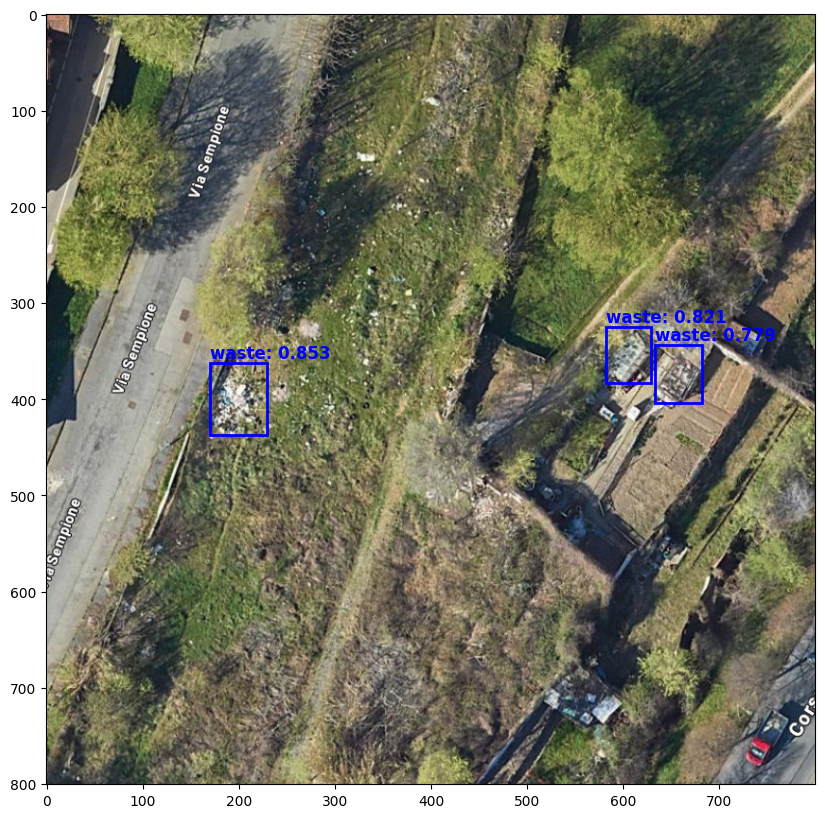

In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Plot image
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)

# Add bounding boxes
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    xmin, ymin, xmax, ymax = box
    width, height = xmax - xmin, ymax - ymin

    # Create a rectangle patch
    rect = patches.Rectangle(
        (xmin, ymin), width, height, linewidth=2, edgecolor="blue", facecolor="none"
    )
    ax.add_patch(rect)

    # Add label
    label_text = f"waste: {round(score.item(), 3)}"
    ax.text(xmin, ymin - 5, label_text, color="blue", fontsize=12, weight="bold")